# Workflow Debugging

['dj_3', 'dj_5', 'dj_7', 'dj_9', 'dj_11', 'dj_13', 'dj_15', 'dj_17', 'dj_19', 'dj_21', 'dj_23', 'dj_25', 'dj_27', 'dj_29', 'dj_31', 'dj_33', 'dj_35', 'dj_37', 'dj_39', 'dj_41', 'dj_43', 'dj_45', 'dj_47', 'dj_49', 'dj_51', 'dj_53', 'dj_55', 'dj_57', 'dj_59', 'dj_61', 'dj_63', 'dj_65', 'dj_67', 'dj_69', 'dj_71', 'dj_73', 'dj_75', 'dj_77', 'dj_79', 'dj_81', 'dj_83', 'dj_85', 'dj_87', 'dj_89', 'dj_91', 'dj_93', 'dj_95', 'dj_97', 'dj_99', 'dj_101', 'dj_103', 'dj_105', 'dj_107', 'dj_109', 'dj_111', 'dj_113', 'dj_115', 'dj_117', 'dj_119', 'dj_121', 'dj_123', 'dj_125', 'dj_127', 'dj_129', 'grover-noancilla_3', 'grover-noancilla_5', 'grover-noancilla_7', 'grover-noancilla_9', 'grover-v-chain_3', 'ghz_3', 'ghz_5', 'ghz_7', 'ghz_9', 'ghz_11', 'ghz_13', 'ghz_15', 'ghz_17', 'ghz_19', 'ghz_21', 'ghz_23', 'ghz_25', 'ghz_27', 'ghz_29', 'ghz_31', 'ghz_33', 'ghz_35', 'ghz_37', 'ghz_39', 'ghz_41', 'ghz_43', 'ghz_45', 'ghz_47', 'ghz_49', 'ghz_51', 'ghz_53', 'ghz_55', 'ghz_57', 'ghz_59', 'ghz_61', 'ghz_63'

2022-04-13 10:00:19.873302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-13 10:00:19.873402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-13 10:00:19.961227: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/9 [=========================>....] - ETA: 0s - loss: 6.4126 - accuracy: 0.3945

2022-04-13 10:00:20.114106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 11ms/step - loss: 5.8971 - accuracy: 0.4196
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 2.0416 - accuracy: 0.4965
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 1.4834 - accuracy: 0.4790
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.9543 - accuracy: 0.6713
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.9353 - accuracy: 0.6713
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8657 - accuracy: 0.6469
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8686 - accuracy: 0.6503
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 1.0366 - accuracy: 0.6713
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8060 - accuracy: 0.7273
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.7919 - accuracy: 0.6783
Epoch 11/100
9/9 [======================

9/9 [==============================] - 0s 7ms/step - loss: 0.4846 - accuracy: 0.8392
Epoch 85/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4301 - accuracy: 0.8077
Epoch 86/100
9/9 [==============================] - 0s 6ms/step - loss: 0.4079 - accuracy: 0.8497
Epoch 87/100
9/9 [==============================] - 0s 6ms/step - loss: 0.3647 - accuracy: 0.8427
Epoch 88/100
9/9 [==============================] - 0s 6ms/step - loss: 0.3296 - accuracy: 0.8497
Epoch 89/100
9/9 [==============================] - 0s 6ms/step - loss: 0.3447 - accuracy: 0.8776
Epoch 90/100
9/9 [==============================] - 0s 6ms/step - loss: 0.3022 - accuracy: 0.8671
Epoch 91/100
9/9 [==============================] - 0s 6ms/step - loss: 0.4162 - accuracy: 0.8252
Epoch 92/100
9/9 [==============================] - 0s 7ms/step - loss: 0.3225 - accuracy: 0.8846
Epoch 93/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4629 - accuracy: 0.8217
Epoch 94/100
9/9 [===============

2022-04-13 10:00:26.028632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 10:00:26.219832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data: 0.813008189201355% 
 Error on test data: 0.18699181079864502
qaoa_17  predicted:  3  should be:  1  diff:  137.74676401729062
qftentangled_21  predicted:  0  should be:  1  diff:  72.21239965180348
ghz_129  predicted:  5  should be:  0  diff:  0
su2random_21  predicted:  0  should be:  3  diff:  307.0730468753527
qpeexact_13  predicted:  2  should be:  1  diff:  998682.4862172357
ghz_11  predicted:  5  should be:  2  diff:  55.554484311974086
qft_15  predicted:  0  should be:  1  diff:  21.208530805687587
su2random_11  predicted:  0  should be:  2  diff:  1463.482242658816
portfolioqaoa_11  predicted:  0  should be:  2  diff:  1711.889430702969
qftentangled_15  predicted:  0  should be:  3  diff:  21.851556135326973
graphstate_67  predicted:  0  should be:  3  diff:  248.94506048472817
wstate_107  predicted:  5  should be:  0  diff:  237.68546281071667
dj_47  predicted:  0  should be:  5  diff:  227.45110745720126
graphstate_71  predicted:  0  should be:  3  diff

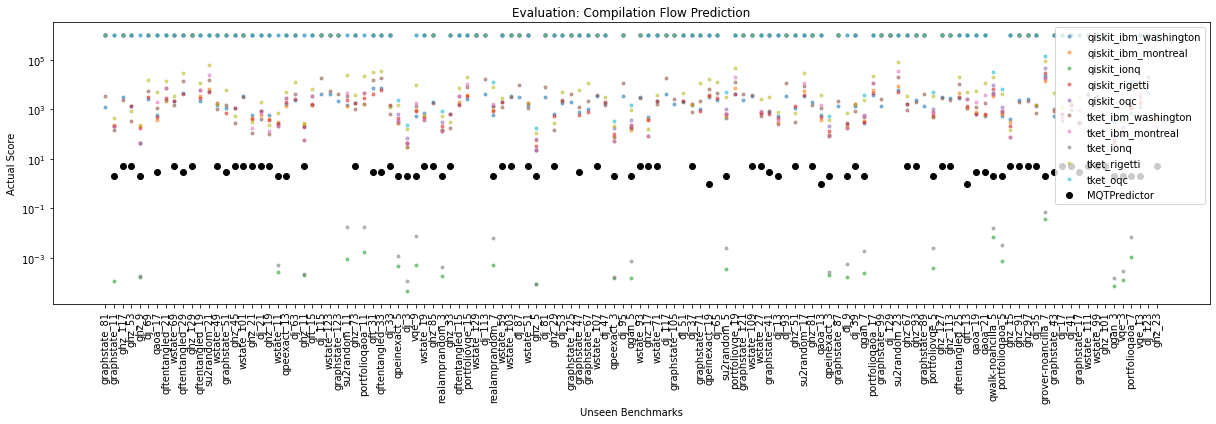

In [1]:
from evaluator.eval import extract_training_data_from_json, train_simple_ml_model
import numpy as np
training_data, names_list, scores_list = extract_training_data_from_json("big_1.json")
print(names_list)
X, y = zip(*training_data)
train_simple_ml_model(X,y, True, names_list, scores_list)

# Debugging

In [1]:
from evaluator import eval
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType

In [6]:
benchmarks = [
    "dj",
    "grover-noancilla",
    "grover-v-chain",
    "ghz",
    "graphstate",
    "qft",
    "qftentangled",
    "qpeexact",
    "qpeinexact",
    "qwalk-noancilla",
    "qwalk-v-chain",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    "qaoa",
    "portfoliovqe",
    "portfolioqaoa",
    "qgan",
]
res = []
timeout=10
for benchmark in benchmarks:
    for num_qubits in range(4, 5, 1):
        print(benchmark, num_qubits)
        qc = eval.timeout_watcher(
            get_one_benchmark,
            [benchmark, 1, num_qubits],
            timeout,
        )
        if not qc:
            break
        print("1")
        actual_num_qubits = qc.num_qubits
        qiskit_gates = eval.timeout_watcher(eval.get_qiskit_gates, [qc], timeout)
        if not qiskit_gates:
            break
        try:
            qc_tket = qiskit_to_tk(qc)
            ops_list = qc.count_ops()
            print("2")
            feature_vector = eval.dict_to_featurevector(ops_list, actual_num_qubits)
            tket_gates = eval.timeout_watcher(eval.get_tket_gates, [qc_tket], timeout)
            
            print("3")
            if not tket_gates:
                break
            benchmark_name = benchmark + "_" + str(num_qubits)
            res.append(
                (
                    benchmark,
                    feature_vector,
                    qiskit_gates + tket_gates,
                    benchmark_name,
                )
            )
        except Exception as e:
            print("fail: ", e)


dj 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
grover-noancilla 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
grover-v-chain 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
ghz 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
graphstate 4
1
2
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
3
qft 4
1


KeyboardInterrupt: 